# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Storage Solutions** </center>
---
**Profesor**: Pablo Camarillo Ramirez

# Create SparkSession

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on data joins") \
    .master("spark://55753eb702bd:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

# Create DataFrames

In [ ]:
from pcamarillor.spark_utils import SparkUtils
from pyspark.sql.functions import get_json_object

agencies_schema = SparkUtils.generate_schema([("agency_id", "string"), ("agency_info", "string")])
cars_schema = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
customers_schema = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
rental_cars_schema = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

base_path = "/opt/spark/work-dir/data/"

agencies_df = spark.read \
                .schema(agencies_schema) \
                .option("header", "true") \
                .csv(base_path + "car_service/agencies")
agencies_df = agencies_df.withColumn("agency_name", get_json_object(agencies_df.agency_info, "$.agency_name"))


cars_df = spark.read.option("header", "true").schema(cars_schema).csv(base_path + "car_service/cars")

brands_df = spark.read.option("header", "true").schema(cars_schema).csv(base_path + "car_service/brands")

customers_df = spark.read.option("header", "true").schema(customers_schema).csv(base_path + "car_service/customers")

rental_cars_df = spark.read.option("header", "true").schema(rental_cars_schema).csv(base_path + "car_service/rentals")


# Extract JSON info

In [ ]:
agencies_df = agencies_df.withColumn("agency_name", get_json_object(agencies_df.agency_info, "$.agency_name")).drop("agency_info")
cars_df = cars_df.withColumn("car_name", get_json_object(cars_df.car_info, "$.car_name")).drop("car_info")
customers_df = customers_df.withColumn("customer_name", get_json_object(customers_df.customer_info, "$.customer_name")).drop("customer_info")

rental_cars_df = rental_cars_df.withColumn("car_id", get_json_object(rental_cars_df.rental_info, '$.car_id')) \
                            .withColumn("customer_id", get_json_object(rental_cars_df.rental_info, '$.customer_id')) \
                            .withColumn("agency_id", get_json_object(rental_cars_df.rental_info, '$.agency_id')) \
                            .drop("rental_info")

# Join transformations

In [ ]:
rental_cars_df = rental_cars_df.join(cars_df, on="car_id", how="left") \
                                .join(customers_df, on="customer_id", how="left") \
                                .join(agencies_df, on="agency_id", how="left") \
                                .drop("agency_id", "customer_id", "car_id")



In [ ]:
rental_cars_df.show(5)

# Persist Data

## Parquet file

In [ ]:
!pwd

In [ ]:
!du -sh data/car_service/rentals/

In [ ]:
rental_cars_df.write \
            .mode("overwrite") \
            .parquet(base_path + "car_service/output/parquet")

In [ ]:
!ls data/car_service/output/parquet/

In [ ]:
!du -sh data/car_service/output/parquet/

In [ ]:
rental_cars_df.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .parquet(base_path + "car_service/output/parquet")

In [ ]:
!ls data/car_service/output/parquet/

In [ ]:
!du -sh data/car_service/output/parquet/

## CSV files

In [ ]:
rental_cars_df.write \
            .partitionBy("agency_name") \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/csv")

In [ ]:
!du -sh data/car_service/output/csv/

In [ ]:
rental_cars_df.write \
            .mode("overwrite") \
            .option("header", True) \
            .csv(base_path + "car_service/output/rentals/csv")

In [ ]:
rental_cars_df.write \
            .mode("overwrite") \
            .parquet(base_path + "car_service/output/rentals/parquet")

In [ ]:
airlines_schema_columns = [("index", "int"), 
     ("airline", "string"), 
     ("flight", "string"),
     ("source_city", "string"),
     ("departure_time", "string"),
     ("stops", "string"),
     ("arrival_time", "string"),
     ("destination_city", "string"),
     ("class", "string"),
     ("duration", "float"),
     ("days_left", "int"),
     ("price", "int")
     ]
airlines_schema = SparkUtils.generate_schema(airlines_schema_columns)

df_airlines = spark.read \
                .option("header", "true") \
                .schema(airlines_schema) \
                .csv(base_path + "/airline/")

from pyspark.sql.functions import max, min
df_airlines.groupBy(df_airlines.airline).agg(max(df_airlines.price), min(df_airlines.price)).show()


In [ ]:
df_final = df_airlines.filter(df_airlines.price < 1500)
df_final.count()

In [ ]:
df_final.write \
              .option("header", True) \
              .mode("overwrite") \
              .csv(base_path + "/airline/output/csv")

In [ ]:
sc.stop()

## Power BI Dashboard

### Cars by customer names

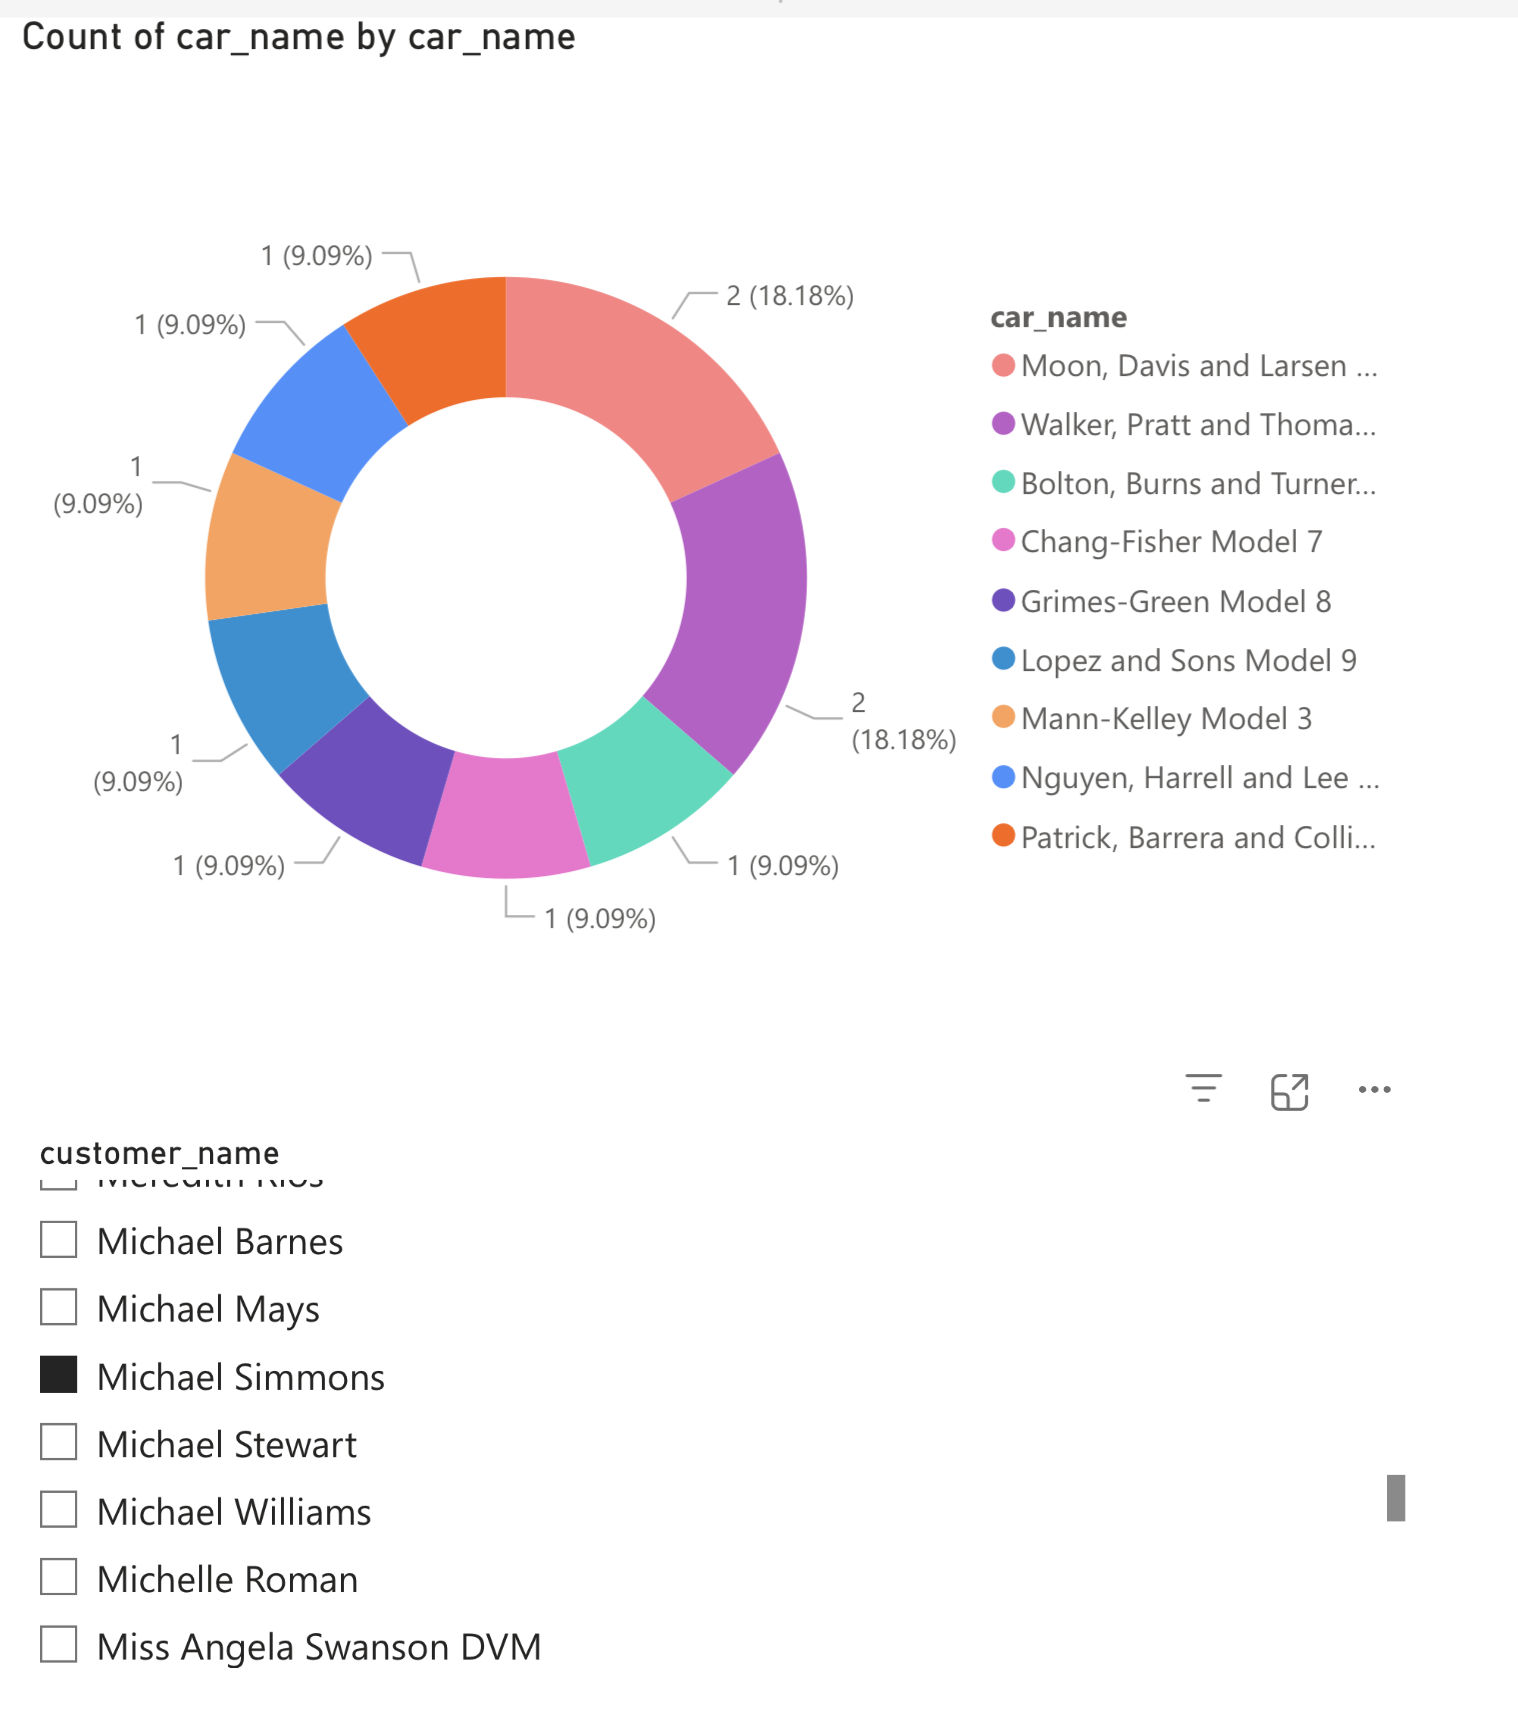